<div class="alert alert-block alert-danger">
    
## Table of Contents

</div>    

[1. Libraries](#Libraries) <br>
[2. Define functions](#def) <br>
[3. Use EEG + EMG + ECG to train XGboost](#all_xgboost) <br>
[4. Use ECG to train XGBoost](#ecg_xgboost) <br>

<div class="alert alert-block alert-warning">

## 1.  Libraries  <a class="anchor" name="Libraries"></a>
    
</div>

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import RFE
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tempfile
import pickle
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix, roc_auc_score
from sklearn.utils import resample

<div class="alert alert-block alert-warning">

## 2.  Define functions  <a class="anchor" name="def"></a>
    
</div>

In [2]:
# Function to parse the multi_entropy string and calculate the mean
def parse_multi_entropy(x):
    # Extract all the floating point numbers from the string
    numbers = re.findall(r"[-+]?\d*\.\d+|\d+", x)
    # Convert the extracted numbers to float and calculate the mean
    return np.mean([float(num) for num in numbers])

In [3]:
# Define a function to calculate signal-to-noise ratio (SNR)
def calculate_snr(signal):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    return mean_signal / std_signal

In [4]:
# Function to perform leave-one-out cross-validation
def loo_cv(clf, file_list, features):
    errors = []
    for i in range(len(file_list)):
        test_file = file_list[i]
        train_files = [file for j, file in enumerate(file_list) if j != i]
        
        # Read test data
        test_df = pd.read_excel(test_file)
        test_df['multi_entropy'] = test_df['multi_entropy'].apply(parse_multi_entropy)
        X_test = test_df[features]
        y_test = test_df['label'].map(label_mapping)
        
        # Read training data
        train_dfs = [pd.read_excel(train_file) for train_file in train_files]
        for train_df in train_dfs:
            train_df['multi_entropy'] = train_df['multi_entropy'].apply(parse_multi_entropy)
        
        train_df = pd.concat(train_dfs)
        X_train = train_df[features]
        y_train = train_df['label'].map(label_mapping)

        # Train the classifier 
        clf.fit(X_train.astype(float), y_train)
        y_pred = clf.predict(X_test.astype(float))
        
        errors.append(1 - accuracy_score(y_test, y_pred))
    
    return np.mean(errors)

In [5]:
# Function to perform leave-one-out cross-validation and store confusion matrices 
def loo_cv_with_confusion_matrix(clf, file_list, features):
    errors = []
    confusion_matrices = []
    
    for i in range(len(file_list)):
        test_file = file_list[i]
        train_files = [file for j, file in enumerate(file_list) if j != i]
        
        # Read test data
        test_df = pd.read_excel(test_file)
        test_df['multi_entropy'] = test_df['multi_entropy'].apply(parse_multi_entropy)
        X_test = test_df[features]
        y_test = test_df['label'].map(label_mapping)
        
        # Read and concatenate training data
        train_dfs = [pd.read_excel(train_file) for train_file in train_files]
        for train_df in train_dfs:
            train_df['multi_entropy'] = train_df['multi_entropy'].apply(parse_multi_entropy)
        train_df = pd.concat(train_dfs)
        X_train = train_df[features]
        y_train = train_df['label'].map(label_mapping)


        # Train the classifier 
        clf.fit(X_train.astype(float), y_train)
        y_pred = clf.predict(X_test.astype(float))
        
        errors.append(1 - accuracy_score(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)
    
    # Calculate mean error and standard deviation of errors
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    
    return mean_error, std_error, confusion_matrices

In [6]:
def loo_cv_signal_quality(clf, file_list, features):
    errors = []
    signal_stats = {'by_sheep': {}, 'by_class': {-1: [], 0: [], 1: []}}
    snr_by_sheep = {}  # Dictionary to store SNR for each sheep
    
    for i in range(len(file_list)):
        test_file = file_list[i]
        train_files = [file for j, file in enumerate(file_list) if j != i]
        
        # Extract file name as sheep_id
        sheep_id = os.path.basename(test_file)
        
        # Read test data
        test_df = pd.read_excel(test_file)
        test_df['multi_entropy'] = test_df['multi_entropy'].apply(parse_multi_entropy)
        X_test = test_df[features]
        y_test = test_df['label'].map(label_mapping)
        
        # Read training data
        train_dfs = [pd.read_excel(train_file) for train_file in train_files]
        for train_df in train_dfs:
            train_df['multi_entropy'] = train_df['multi_entropy'].apply(parse_multi_entropy)
        
        train_df = pd.concat(train_dfs)
        X_train = train_df[features]
        y_train = train_df['label'].map(label_mapping)
  
        
        # Train the classifier 
        clf.fit(X_train.astype(float), y_train)
        y_pred = clf.predict(X_test.astype(float))
        errors.append(1 - accuracy_score(y_test, y_pred))
        
        # Evaluate signal quality variability by sheep
        snr_values = []
        for feature in features:
            snr = calculate_snr(test_df[feature])
            snr_values.append(snr)
        avg_snr = np.mean(snr_values)
        
        if sheep_id not in signal_stats['by_sheep']:
            signal_stats['by_sheep'][sheep_id] = []
        signal_stats['by_sheep'][sheep_id].append(avg_snr)
        
        # Store SNR for the current sheep (file)
        snr_by_sheep[sheep_id] = avg_snr
        
        # Evaluate signal quality variability by class
        for label in signal_stats['by_class'].keys():
            class_df = train_df[train_df['label'] == label]
            snr_values = []
            for feature in features:
                snr = calculate_snr(class_df[feature])
                snr_values.append(snr)
            signal_stats['by_class'][label].append(np.mean(snr_values))
    
    # Calculate and print signal quality statistics
    avg_snr_by_sheep = {sheep_id: np.mean(snrs) for sheep_id, snrs in signal_stats['by_sheep'].items()}
    avg_snr_by_class = {label: np.mean(snrs) for label, snrs in signal_stats['by_class'].items()}
    
    print("Average SNR by Sheep:")
    for sheep_id, avg_snr in avg_snr_by_sheep.items():
        print(f"Sheep {sheep_id}: {avg_snr:.2f}")
    
    print("Average SNR by Class:")
    for label, avg_snr in avg_snr_by_class.items():
        print(f"Class {label}: {avg_snr:.2f}")
    
    return np.mean(errors), snr_by_sheep

In [7]:
# Function to categorize removed features
def categorize_removed_features(removed_features):
    eeg_removed = [feature for feature in removed_features if feature in eeg_features]
    ecg_removed = [feature for feature in removed_features if feature in ecg_features]
    emg_removed = [feature for feature in removed_features if feature in emg_features]
    return eeg_removed, ecg_removed, emg_removed

In [35]:
# Function to plot confusion matrix with percentages and save it
def plot_confusion_matrix(cm, labels, title='Confusion Matrix', filename='confusion_matrix.png'):
    # Calculate percentages
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    
    # Create new confusion matrix with counts and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]
            p = cm_perc[i, j]
            if c == 0:
                annot[i, j] = '0\n0.0%'
            else:
                annot[i, j] = f'{c}\n{p:.1f}%'
    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    cm_perc_df = pd.DataFrame(cm_perc, index=labels, columns=labels)
    
    # Add Total Predicted and Total Actual
    total_actual = cm.sum(axis=1)
    total_predicted = cm.sum(axis=0)
    cm_df['Total Actual'] = total_actual
    cm_df.loc['Total Predicted'] = np.append(total_predicted, np.sum(total_predicted))
    
    total_actual_perc = total_actual / total_actual.sum() * 100
    total_predicted_perc = total_predicted / total_predicted.sum() * 100
    cm_perc_df['Total Actual'] = total_actual_perc
    cm_perc_df.loc['Total Predicted'] = np.append(total_predicted_perc, 100.0)
    
    # Prepare annotations with totals
    annot_df = cm_df.astype(str) + '\n' + cm_perc_df.round(2).astype(str) + '%'
    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=annot_df, fmt='', cmap='Blues', cbar=False, xticklabels=list(cm_df.columns), yticklabels=list(cm_df.index))
    
    # Highlight the Total columns and rows with white background
    for _, spine in plt.gca().spines.items():
        spine.set_visible(True)
    plt.gca().add_patch(plt.Rectangle((cm.shape[1], 0), 1, cm.shape[0], fill=True, facecolor='white', edgecolor='black', lw=1))
    plt.gca().add_patch(plt.Rectangle((0, cm.shape[0]), cm.shape[1], 1, fill=True, facecolor='white', edgecolor='black', lw=1))
    
    # Set title and labels
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    
    # Save the figure
    plt.savefig(filename)
    plt.show()

In [9]:
# Function to calculate average F1 score and accuracy
def calculate_metrics(confusion_matrices):
    all_f1_weighted = []
    all_f1_macro = []
    all_accuracies = []

    for cm in confusion_matrices:
        true_labels = []
        predicted_labels = []
        
        for actual_class in range(len(cm)):
            for predicted_class in range(len(cm[actual_class])):
                true_labels.extend([actual_class] * cm[actual_class][predicted_class])
                predicted_labels.extend([predicted_class] * cm[actual_class][predicted_class])
        
        f1_weighted = f1_score(true_labels, predicted_labels, average='weighted')
        f1_macro = f1_score(true_labels, predicted_labels, average='macro')
        accuracy = accuracy_score(true_labels, predicted_labels)

        all_f1_weighted.append(f1_weighted)
        all_f1_macro.append(f1_macro)
        all_accuracies.append(accuracy)

    average_f1_weighted = np.mean(all_f1_weighted)
    average_f1_macro = np.mean(all_f1_macro)
    average_accuracy = np.mean(all_accuracies)

    return average_f1_weighted, average_f1_macro, average_accuracy

In [10]:
# Define feature categories
eeg_features = [
    'PFD', 'DFA', 'sh_entropy', 'multi_entropy', 'sample_entropy', 'approx_entropy',
    'absolute_delta_power', 'relative_delta_power', 'absolute_theta_power', 'relative_theta_power',
    'absolute_alpha_power', 'relative_alpha_power', 'absolute_belta_power', 'relative_belta_power'
]

# sdrr is similiar with std_hr, mrr is similar with mean_hr
# first remove mrr, then remove sdrr
ecg_features = ['sdrr', 'rmssd', 'mrr', 'mean_hr', 'std_hr', 'min_hr', 'max_hr']

emg_features = [
    'amplitude_mean', 'amplitude_median', 'amplitude_rms', 'amplitude_std', 'amplitude_max',
    'low_power', 'med_power', 'high_power', 'low_rel_power', 'mid_rel_power', 'high_rel_power',
    'dominant_frequency', 'duration'
]

<div class="alert alert-block alert-warning">

## 3.  Use EEG + EMG + ECG to train XGboost  <a class="anchor" name="all_xgboost"></a>
    
</div>


In [11]:
# Combine all features
all_features = eeg_features + ecg_features + emg_features

# Define directories and feature categories
base_dir = "E:\\IEEE Sensor\\IEEE Sensor Xlsx Data\\Merge_data"
file_list = [os.path.join(base_dir, file) for file in os.listdir(base_dir) if file.endswith(".xlsx")]

# Map the labels to positive integers
label_mapping = {-1: 0, 0: 1, 1: 2}

In [12]:
# Initialize classifiers for XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=3)

# Perform RFE manually with a progress bar for XGBoost
min_features_to_select = 1
step = 1

# Combine all data for initial feature selection
combined_df = pd.concat([pd.read_excel(file) for file in file_list])
combined_df['multi_entropy'] = combined_df['multi_entropy'].apply(parse_multi_entropy)
X_combined = combined_df[all_features]
y_combined = combined_df['label'].map(label_mapping)

# Initial set of features for XGBoost
remaining_features_xgb = all_features[:]
best_features_xgb = remaining_features_xgb[:]
best_error_xgb = float('inf')

In [13]:
# EEG+ECG+EMG call
XGB_all_errors, XGB_all_snr_by_sheep = loo_cv_signal_quality(xgb_clf, file_list, remaining_features_xgb)

Average SNR by Sheep:
Sheep 21087_handled_merged_data.xlsx: 4.83
Sheep 20105_handled_merged_data.xlsx: 5.08
Sheep 21071_handled_merged_data.xlsx: 5.82
Sheep 21122_handled_merged_data.xlsx: 3.16
Sheep 21133_handled_merged_data.xlsx: 8.63
Sheep 21173_handled_merged_data.xlsx: 4.27
Sheep 21203_handled_merged_data.xlsx: 4.53
Sheep 20244_handled_merged_data.xlsx: 3.09
Sheep 20252_handled_merged_data.xlsx: 3.73
Sheep 21200_handled_merged_data.xlsx: 4.91
Sheep 21093_handled_merged_data.xlsx: 3.78
Sheep 20112A_handled_merged_data.xlsx: 7.68
Sheep 21165_handled_merged_data.xlsx: 4.63
Sheep 21044_handled_merged_data.xlsx: 7.83
Sheep 21051_handled_merged_data.xlsx: 6.78
Sheep 21126_handled_merged_data.xlsx: 3.07
Average SNR by Class:
Class -1: 3.11
Class 0: 2.18
Class 1: 2.80


In [14]:
pbar_xgb = tqdm(total=len(remaining_features_xgb) - min_features_to_select, desc="RFECV Progress for XGBoost")

while len(remaining_features_xgb) > min_features_to_select:
    # Perform leave-one-out CV for the current set of features
    current_error_xgb = loo_cv(xgb_clf, file_list, remaining_features_xgb)
    
    # Update the best set of features if the current error is lower
    if current_error_xgb < best_error_xgb:
        best_error_xgb = current_error_xgb
        best_features_xgb = remaining_features_xgb[:]
    
    # Remove the least important feature
    importances_xgb = xgb_clf.fit(X_combined[remaining_features_xgb], y_combined).feature_importances_
    
    least_important_feature_xgb = remaining_features_xgb[np.argmin(importances_xgb)]
    remaining_features_xgb.remove(least_important_feature_xgb)
    
    pbar_xgb.update(step)

pbar_xgb.close()

print(f'XGBoost selected features: {list(best_features_xgb)}')

RFECV Progress for XGBoost: 100%|██████████████████████████████████████████████████████| 33/33 [12:08<00:00, 22.09s/it]

XGBoost selected features: ['multi_entropy', 'absolute_belta_power', 'mean_hr', 'min_hr', 'amplitude_mean', 'amplitude_median', 'low_power']


In [15]:
# Determine removed features for XGBoost
removed_features_xgb = set(all_features) - set(best_features_xgb)
print(f'XGBoost Removed features: {list(removed_features_xgb)}')

XGBoost Removed features: ['absolute_delta_power', 'DFA', 'amplitude_max', 'relative_alpha_power', 'low_rel_power', 'std_hr', 'max_hr', 'rmssd', 'approx_entropy', 'relative_belta_power', 'relative_delta_power', 'dominant_frequency', 'sample_entropy', 'amplitude_rms', 'high_power', 'PFD', 'amplitude_std', 'duration', 'sh_entropy', 'absolute_alpha_power', 'mrr', 'relative_theta_power', 'med_power', 'absolute_theta_power', 'mid_rel_power', 'sdrr', 'high_rel_power']


In [16]:
# Perform Random Search for best hyperparameters for XGBoost
param_dist = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_dist, n_iter=50, scoring='accuracy', verbose=1, random_state=42)
random_search.fit(X_combined[best_features_xgb], y_combined)

best_xgb_clf = random_search.best_estimator_
print(f'Best XGBoost parameters: {random_search.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [17]:
# Evaluate the selected features with the best hyperparameters for XGBoost
print("Evaluating selected features for XGBoost with best hyperparameters...")
xgb_all_mean_error, xgb_all_std_error, xgb_all_confusion_matrices = loo_cv_with_confusion_matrix(best_xgb_clf, file_list, best_features_xgb)
print(f'XGBoost Mean Validation Error with selected features: {xgb_all_mean_error}')
print(f'XGBoost Standard Deviation of Validation Error with selected features: {xgb_all_std_error}')

with open('E:/IEEE Sensor/IEEE Sensor Xlsx Data/xgb_confusion_matrices.pkl', 'wb') as f:
    pickle.dump(xgb_all_confusion_matrices, f)

Evaluating selected features for XGBoost with best hyperparameters...
XGBoost Mean Validation Error with selected features: 0.12104881607565479
XGBoost Standard Deviation of Validation Error with selected features: 0.07923971903619549


Feature ranking (XGBoost):
absolute_belta_power: 0.33821457624435425
multi_entropy: 0.17083388566970825
mean_hr: 0.12430162727832794
min_hr: 0.12027617543935776
amplitude_mean: 0.08832794427871704
amplitude_median: 0.0838301032781601
low_power: 0.07421577721834183


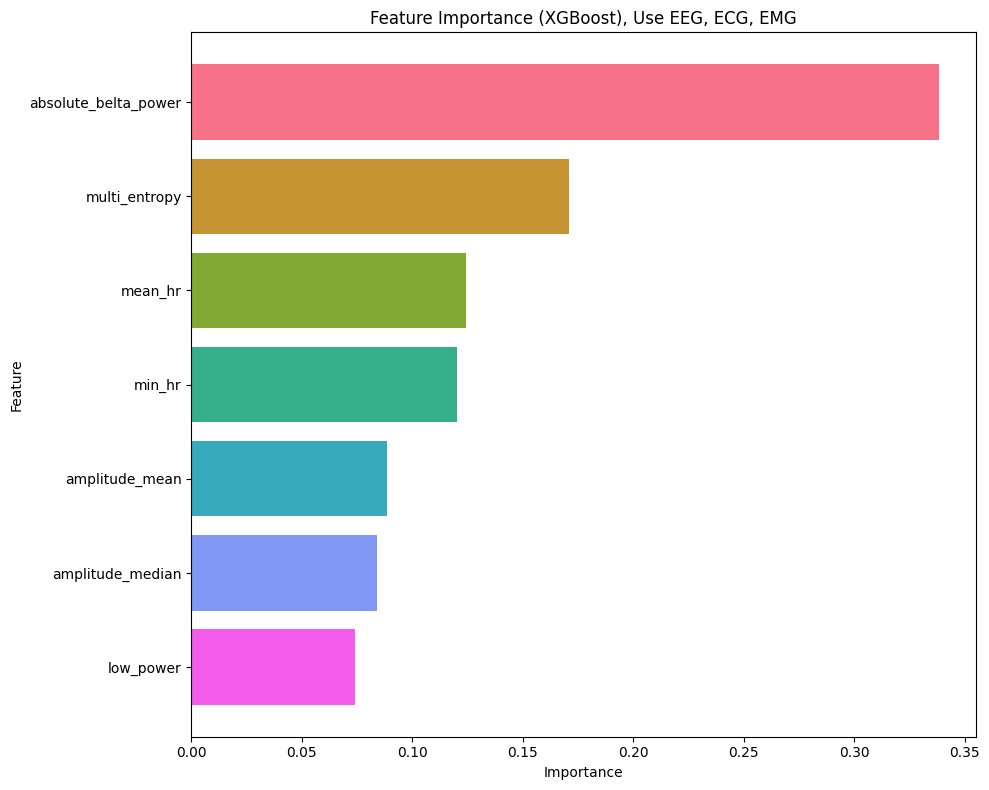

In [18]:
# Feature importance ranking and plotting for XGBoost
importances_xgb = best_xgb_clf.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
feature_ranking_xgb = {best_features_xgb[i]: importances_xgb[i] for i in indices_xgb}

print("Feature ranking (XGBoost):")
for feature, importance in feature_ranking_xgb.items():
    print(f"{feature}: {importance}")

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 8))
plt.title("Feature Importance (XGBoost), Use EEG, ECG, EMG")
colors = sns.color_palette('husl', len(best_features_xgb))
plt.barh(range(len(best_features_xgb)), importances_xgb[indices_xgb], color=colors, align='center')
plt.yticks(range(len(best_features_xgb)), [best_features_xgb[i] for i in indices_xgb])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

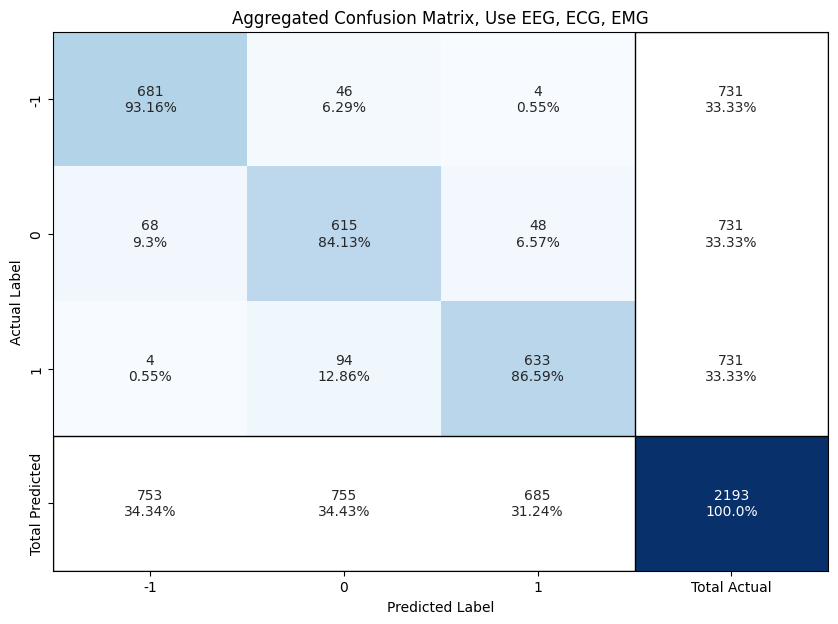

Average F1 Score (Weighted): 0.8768
Average F1 Score (Macro): 0.8768
Average Accuracy: 0.8790


In [37]:
#### Load the confusion matrices from the pickle file
with open("E:/IEEE Sensor/IEEE Sensor Xlsx Data/xgb_confusion_matrices.pkl", "rb") as f:
    confusion_matrices = pickle.load(f)

# Aggregate confusion matrices
aggregated_cm = np.sum(confusion_matrices, axis=0)
labels = [-1, 0, 1]

# Plot the aggregated confusion matrix
plot_confusion_matrix(aggregated_cm, labels, title='Aggregated Confusion Matrix, Use EEG, ECG, EMG', filename='')

# Calculate and print the average F1 scores and accuracy
average_f1_weighted, average_f1_macro, average_accuracy = calculate_metrics(confusion_matrices)
print(f'Average F1 Score (Weighted): {average_f1_weighted:.4f}')
print(f'Average F1 Score (Macro): {average_f1_macro:.4f}')
print(f'Average Accuracy: {average_accuracy:.4f}')

In [20]:
aggregated_cm

array([[681,  46,   4],
       [ 68, 615,  48],
       [  4,  94, 633]], dtype=int64)

<div class="alert alert-block alert-warning">

## 4.  Use EEG to train XGboost  <a class="anchor" name="ecg_xgboost"></a>
    
</div>


In [21]:
# only ECG feature
selected_features = ecg_features

# Separate features and target
X = combined_df[selected_features]
y = combined_df['label'].map(label_mapping)

# Initialize classifiers for XGBoost
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softmax', num_class=3)

# Perform RFE manually with a progress bar for XGBoost
remaining_features_xgb = selected_features[:]
best_features_xgb = remaining_features_xgb[:]
best_error_xgb = float('inf')

In [22]:
# ECG call
XGB_ECG_errors, XGB_ECG_snr_by_sheep = loo_cv_signal_quality(xgb_clf, file_list, selected_features)

Average SNR by Sheep:
Sheep 21087_handled_merged_data.xlsx: 6.06
Sheep 20105_handled_merged_data.xlsx: 5.93
Sheep 21071_handled_merged_data.xlsx: 7.87
Sheep 21122_handled_merged_data.xlsx: 6.35
Sheep 21133_handled_merged_data.xlsx: 7.05
Sheep 21173_handled_merged_data.xlsx: 5.29
Sheep 21203_handled_merged_data.xlsx: 6.11
Sheep 20244_handled_merged_data.xlsx: 5.53
Sheep 20252_handled_merged_data.xlsx: 6.73
Sheep 21200_handled_merged_data.xlsx: 7.23
Sheep 21093_handled_merged_data.xlsx: 5.41
Sheep 20112A_handled_merged_data.xlsx: 5.48
Sheep 21165_handled_merged_data.xlsx: 8.66
Sheep 21044_handled_merged_data.xlsx: 26.28
Sheep 21051_handled_merged_data.xlsx: 7.27
Sheep 21126_handled_merged_data.xlsx: 3.67
Average SNR by Class:
Class -1: 3.64
Class 0: 3.24
Class 1: 3.29


In [23]:
pbar_xgb = tqdm(total=len(remaining_features_xgb) - min_features_to_select, desc="RFECV Progress for XGBoost")

while len(remaining_features_xgb) > min_features_to_select:
    # Perform leave-one-out CV for the current set of features
    current_error_xgb = loo_cv(xgb_clf, file_list, remaining_features_xgb)
    
    # Update the best set of features if the current error is lower
    if current_error_xgb < best_error_xgb:
        best_error_xgb = current_error_xgb
        best_features_xgb = remaining_features_xgb[:]
    
    # Remove the least important feature
    importances_xgb = xgb_clf.fit(X[remaining_features_xgb], y).feature_importances_
    least_important_feature_xgb = remaining_features_xgb[np.argmin(importances_xgb)]
    remaining_features_xgb.remove(least_important_feature_xgb)
    
    pbar_xgb.update(step)

pbar_xgb.close()

print(f'XGBoost selected features: {list(best_features_xgb)}')

RFECV Progress for XGBoost: 100%|████████████████████████████████████████████████████████| 6/6 [02:11<00:00, 21.89s/it]

XGBoost selected features: ['sdrr', 'mean_hr', 'std_hr', 'min_hr', 'max_hr']


In [24]:
# Determine removed features for XGBoost
removed_features_xgb = set(X.columns) - set(best_features_xgb)
print(f'XGBoost Removed features: {list(removed_features_xgb)}')

XGBoost Removed features: ['mrr', 'rmssd']


In [25]:
print(f'XGBoost selected features: {list(best_features_xgb)}')

XGBoost selected features: ['sdrr', 'mean_hr', 'std_hr', 'min_hr', 'max_hr']


In [26]:
# Hyperparameter tuning with RandomizedSearchCV for XGBoost
param_dist_xgb = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

random_search_xgb = RandomizedSearchCV(xgb_clf, param_distributions=param_dist_xgb, n_iter=50, scoring='accuracy', cv=len(file_list)-1, verbose=1, random_state=42)
random_search_xgb.fit(X[best_features_xgb], y)

best_xgb_clf = random_search_xgb.best_estimator_
print(f'Best XGBoost parameters: {random_search_xgb.best_params_}')

Fitting 15 folds for each of 50 candidates, totalling 750 fits
Best XGBoost parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 1.0}


Feature ranking (XGBoost):
min_hr: 0.3121756911277771
mean_hr: 0.2854834496974945
sdrr: 0.16105619072914124
std_hr: 0.1325186938047409
max_hr: 0.1087660863995552


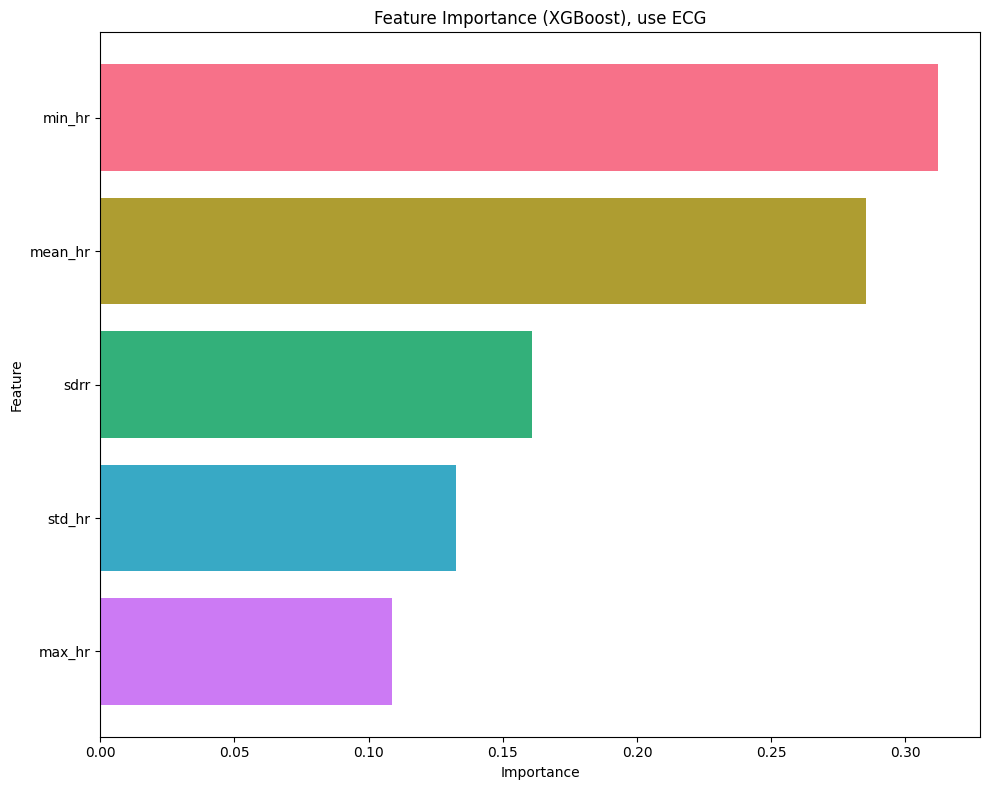

In [27]:
# Feature importance ranking and plotting for XGBoost
importances_xgb = best_xgb_clf.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
feature_ranking_xgb = {best_features_xgb[i]: importances_xgb[i] for i in indices_xgb}

print("Feature ranking (XGBoost):")
for feature, importance in feature_ranking_xgb.items():
    print(f"{feature}: {importance}")

# Plot feature importance for XGBoost
plt.figure(figsize=(10, 8))
plt.title("Feature Importance (XGBoost), use ECG")
colors = sns.color_palette('husl', len(best_features_xgb))
plt.barh(range(len(best_features_xgb)), importances_xgb[indices_xgb], color=colors, align='center')
plt.yticks(range(len(best_features_xgb)), [best_features_xgb[i] for i in indices_xgb])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()
plt.show()

In [28]:
# Evaluate the selected features with the best hyperparameters for XGBoost
print("Evaluating selected features for XGBoost with best hyperparameters...")
xgb_ecg_mean_error, xgb_ecg_std_error, xgb_confusion_matrices_ecg = loo_cv_with_confusion_matrix(best_xgb_clf, file_list, best_features_xgb)
print(f'XGBoost Mean Validation Error with selected features: {xgb_ecg_mean_error}')
print(f'XGBoost Standard Deviation of Validation Error with selected features: {xgb_ecg_std_error}')

with open('E:/IEEE Sensor/IEEE Sensor Xlsx Data/xgb_confusion_matrices_no_EEG_EMG.pkl', 'wb') as f:
    pickle.dump(xgb_confusion_matrices_ecg, f)

Evaluating selected features for XGBoost with best hyperparameters...
XGBoost Mean Validation Error with selected features: 0.3603154042740244
XGBoost Standard Deviation of Validation Error with selected features: 0.17082436953122504


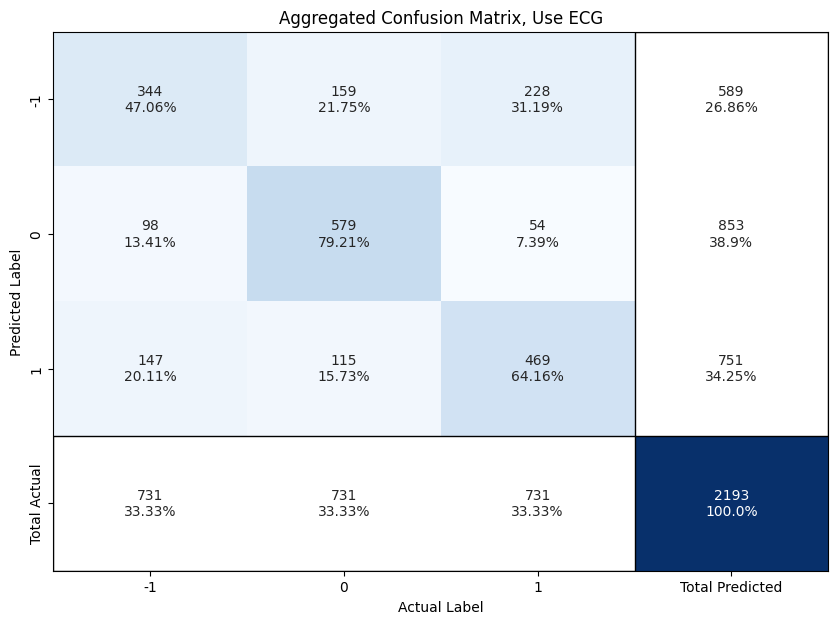

Average F1 Score (Weighted): 0.6257
Average F1 Score (Macro): 0.6257
Average Accuracy: 0.6397


In [32]:
# Load the confusion matrices from the pickle file
with open("E:/IEEE Sensor/IEEE Sensor Xlsx Data/xgb_confusion_matrices_no_EEG_EMG.pkl", "rb") as f:
    confusion_matrices = pickle.load(f)

# Aggregate confusion matrices
aggregated_cm = np.sum(confusion_matrices, axis=0)
labels = [-1, 0, 1]

# Plot the aggregated confusion matrix
plot_confusion_matrix(aggregated_cm, labels, title='Aggregated Confusion Matrix, Use ECG', filename='E:/IEEE Sensor/Figures/xgb_confusion_matrices_no_EEG_EMG.png')

# Calculate and print the average F1 scores and accuracy
average_f1_weighted, average_f1_macro, average_accuracy = calculate_metrics(confusion_matrices)
print(f'Average F1 Score (Weighted): {average_f1_weighted:.4f}')
print(f'Average F1 Score (Macro): {average_f1_macro:.4f}')
print(f'Average Accuracy: {average_accuracy:.4f}')